<a href="https://colab.research.google.com/github/saaaax/EL7007/blob/main/text_deteccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python

In [ ]:
!wget https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb



--2025-05-07 16:01:39--  https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb [following]
--2025-05-07 16:01:39--  https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96662756 (92M) [application/octet-stream]
Saving to: ‘frozen_east_text_detection.pb’

frozen_east_text_de 100%[===================>]  92.18M   108MB/s    in 0.9s    

2025

In [ ]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow

def detect_text_east(image_path, model_path='frozen_east_text_detection.pb', conf_threshold=0.3):
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]


    # Definir la nueva altura/ancho (divisible por 32)
    newW, newH = (32*7, 32*7)
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net = cv2.dnn.readNet(model_path)
    net.setInput(blob)
    (scores, geometry) = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])

    # Post-procesar para extraer las cajas
    (rects, confidences) = decode_predictions(scores, geometry, conf_threshold)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    i=1
    # Recortar
    for (startX, startY, endX, endY) in boxes:
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        roi = orig[startY-5:endY+5, startX-5:endX+5]
        # Guardar cada región
        filename = f"resultado_{model_path}/region_{i}.png"
        cv2.imwrite(filename, roi)
        print(f"[INFO] Región guardada: {filename}")
        i += 1


    # Dibujar las cajas
    for (startX, startY, endX, endY) in boxes:
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # Mostrar imagen con cajas
    cv2_imshow(orig)

    # Retornar si se encontró texto
    return i


def decode_predictions(scores, geometry, conf_threshold):
    numRows, numCols = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        x0 = geometry[0, 0, y]
        x1 = geometry[0, 1, y]
        x2 = geometry[0, 2, y]
        x3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < conf_threshold:
                continue

            offsetX, offsetY = x * 4.0, y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = x0[x] + x2[x]
            w = x1[x] + x3[x]

            endX = int(offsetX + (cos * x1[x]) + (sin * x2[x]))
            endY = int(offsetY - (sin * x1[x]) + (cos * x2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(float(scoresData[x]))

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []
    boxes = boxes.astype("float")
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2 if probs is None else np.array(probs)

    idxs = np.argsort(idxs)

    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)

        xx1 = np.maximum(x1[last], x1[idxs[:-1]])
        yy1 = np.maximum(y1[last], y1[idxs[:-1]])
        xx2 = np.minimum(x2[last], x2[idxs[:-1]])
        yy2 = np.minimum(y2[last], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:-1]]

        idxs = np.delete(idxs, np.concatenate(([len(idxs) - 1],
                                               np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")


[INFO] Región guardada: resultado_frozen_east_text_detection.pb/region_1.png
[INFO] Región guardada: resultado_frozen_east_text_detection.pb/region_2.png
[INFO] Región guardada: resultado_frozen_east_text_detection.pb/region_3.png
[INFO] Región guardada: resultado_frozen_east_text_detection.pb/region_4.png
[INFO] Región guardada: resultado_frozen_east_text_detection.pb/region_5.png


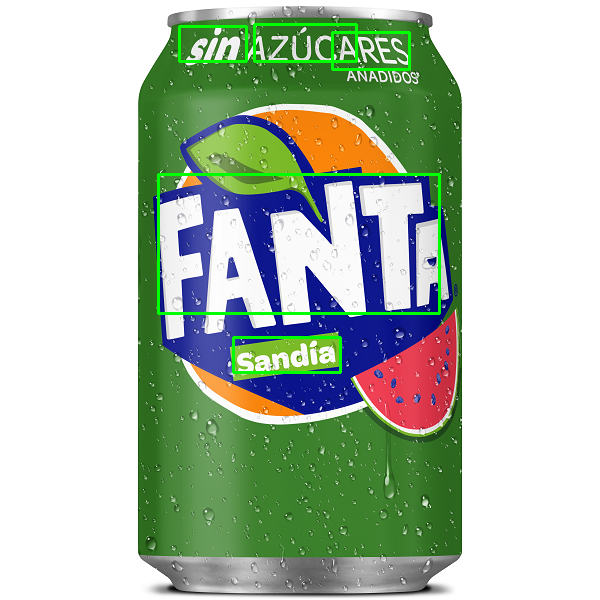

In [ ]:
has_text = detect_text_east("/content/17.png")